# FDEM Part 1: Extension - impact of the radius of the pipe on the extent of the static shielding region

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines a model similar to the scale model that was examined in figure 3 [Augustin et al. (1989)](https://doi.org/10.1190/1.1442581). This notebook was used to produce Figures 8-10  in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [1]:
# core python packages
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.constants import mu_0
import ipywidgets
import string
import os
import tarfile

# SimPEG and discretize
import discretize
from discretize import utils
from SimPEG.EM import FDEM
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


# casing utilities
import casingSimulations as casingSim

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 10

In [3]:
simDir = 'FDEM_Augustin1'  # create a simulation directory where results can be saved. 

## model parameters

In [4]:
casing_mur = [150]  # to examine multiple permeabilities, add them to this list eg [50, 100, 150]
sigma_casing = [3.5e7]  # to examine multiple conductivities, add them to this list
sigma_permeable_casing = 8e6  # conductivity of the permeable casing

In [5]:
sigma_air = 1e-4
sigma_back = 1e-4
casing_t_iron = 0.004 
casing_t_copper = 0.002 
casing_d = [0.015, 0.03, 0.06, 0.12] 
casing_l = 9  # 9m long casing

def get_model(mur, sig, casing_t, d):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sig,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = d+casing_t,  # 0.06 mm is inner casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

In [6]:
model_names_permeable = ["casing_{}".format(d) for d in casing_d]

In [7]:
# conductive, permeable models
model_dict = {
    key: get_model(casing_mur[0], sigma_permeable_casing, casing_t_iron, d) for key, d in zip(model_names_permeable, casing_d)
}


model_names = model_names_permeable
# model_dict = {}
# model_dict.update(model_dict_permeable)
# model_dict.update(model_dict_conductive)

In [ ]:
model_dict[model_names[-1]].serialize()

In [8]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_0.015', 'casing_0.03', 'casing_0.06', 'casing_0.12']

In [9]:
# frequencies to run the simulation at
freqs = [1e-1]
# freqs = np.logspace(-1, 4, 40) # frequency range used in published figure 
# freqs = np.logspace(-1, 4, 20) # use less frequencies if you want to see results sooner! 
for mod in model_dict.values():
    mod.freqs = freqs

## Mesh

In [17]:
# parameters defining the core region of the mesh
csx2 = 0.05  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = mod.casing_t # cell size in the z-direction 
domainx2 = 5  # go out 500m from the well

# padding parameters
npadx, npadz = 30, 37  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4


# # theta discretization
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
# hy = np.r_[hy, hy]
# hy = hy*2*np.pi / hy.sum()


# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=model_dict[model_names[-1]],  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [18]:
mesh_generator = get_mesh(model_dict[model_names[2]])
print("number of cells in the mesh: {}".format(mesh_generator.mesh.nC))

number of cells in the mesh: 303420


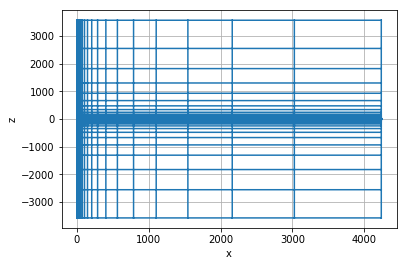

In [19]:
mesh_generator.mesh.plotGrid()

## Physical Properties

In [20]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.items()
}

### Condutivity

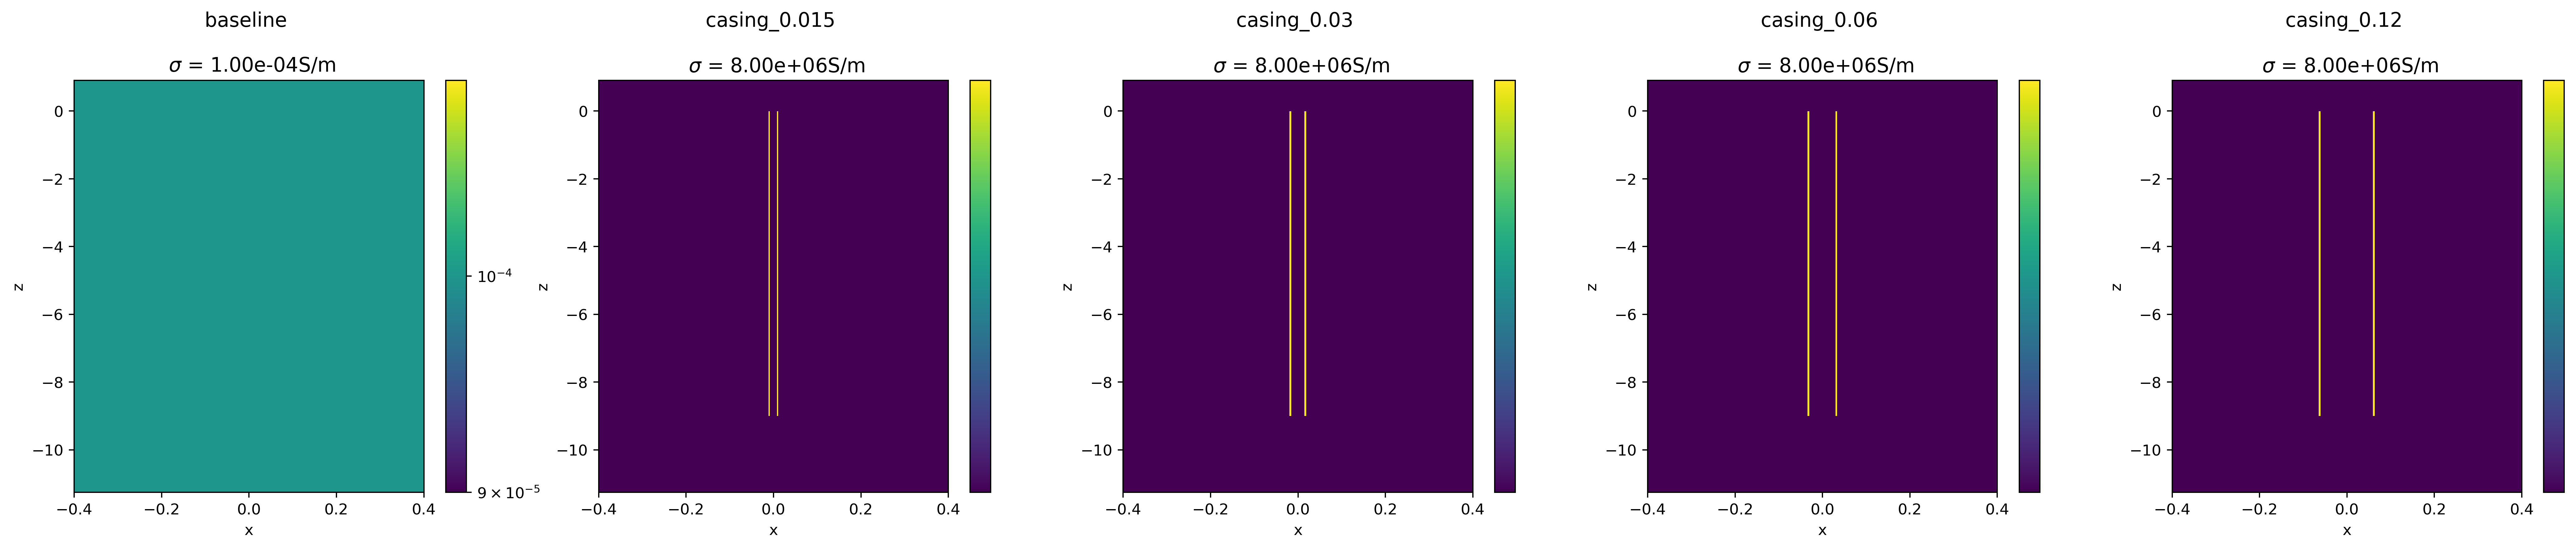

In [21]:
# Plot the models
xlim = 0.4*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.25*casing_l, 0.1*casing_l]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

### Permeability

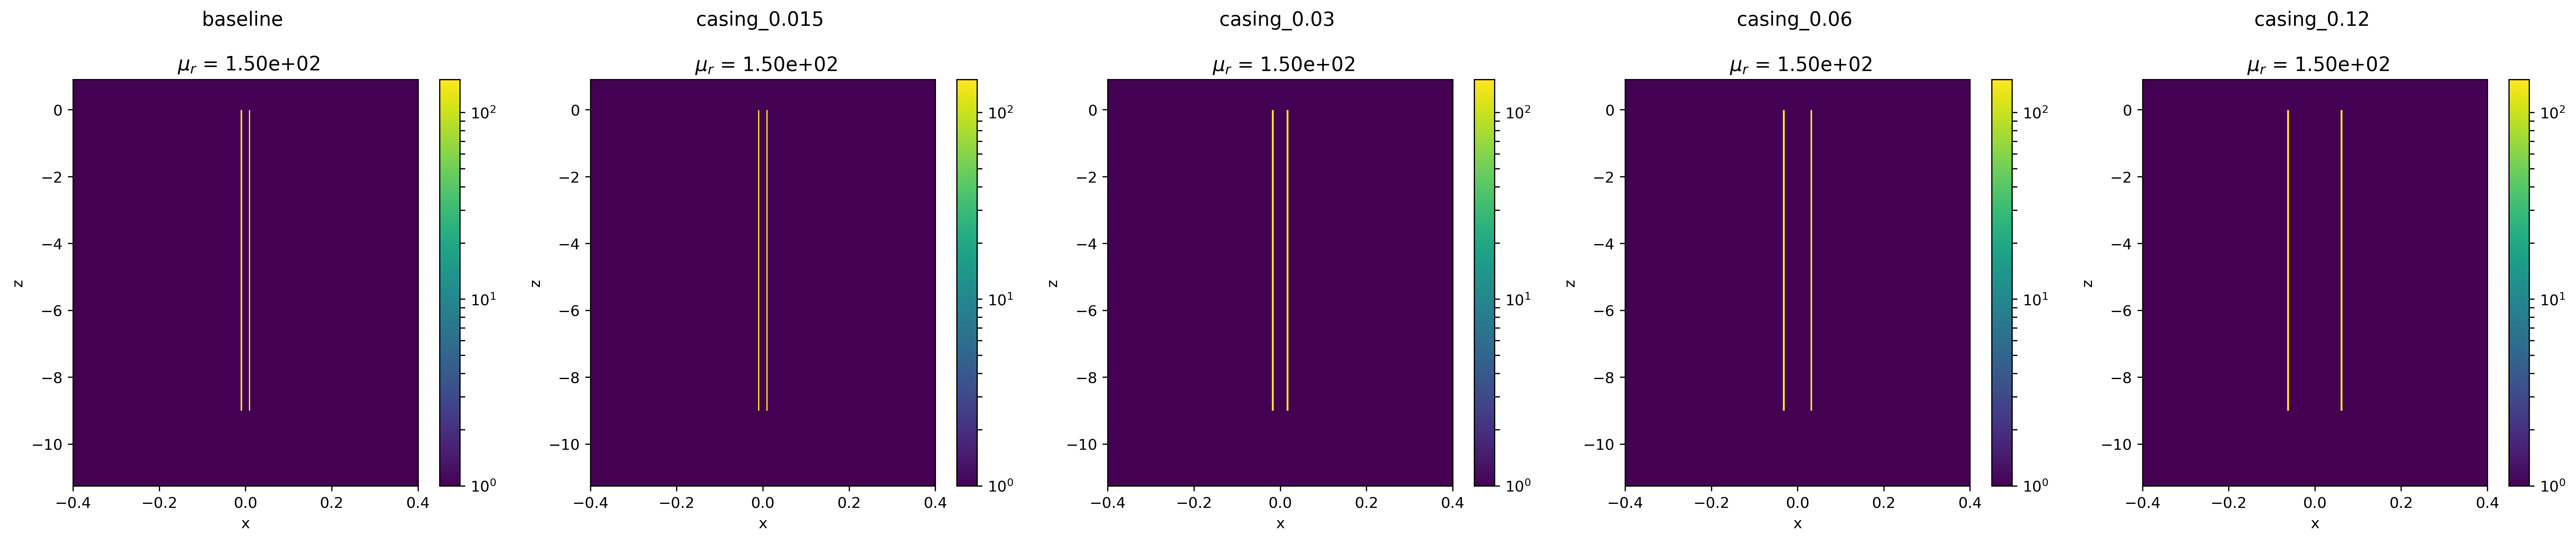

In [22]:
# Plot the models
xlim = 0.4*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.25*casing_l, 0.1*casing_l]  #np.r_[-1.5*casing_l, 0.1*casing_l]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     mesh_generator.mesh.plotGrid(ax=a) # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Survey parameters

In [23]:
z_half = -casing_l/2.

In [24]:
rx_locs = discretize.utils.ndgrid(
    np.r_[0], np.r_[0], 
    mesh_generator.mesh.vectorNz[(mesh_generator.mesh.vectorNz <= 0)&(mesh_generator.mesh.vectorNz >= -9)]
)

In [25]:
rx1_re = FDEM.Rx.Point_bSecondary(rx_locs, orientation="z", component="real")
# rx1_im = FDEM.Rx.Point_b(rx_locs1, orientation="z", component="imag")

# rx2_re = FDEM.Rx.Point_b(rx_locs2, orientation="z", component="real")
# rx2_im = FDEM.Rx.Point_b(rx_locs2, orientation="z", component="imag")

In [26]:
# loop_radius = [0.06, 0.3, 0.6, 3, 6]  # uncomment if you would like to examine more than one loop radius
loop_radius = 0.6

In [27]:
src_list = [FDEM.Src.CircularLoop(
    [rx1_re], f, np.r_[0., 0., z_half], orientation="z", moment=1, radius=loop_radius
) for f in freqs]

# src_list1_flat = [item for sublist in src_list1 for item in sublist]
# src_list2_flat = [item for sublist in src_list2 for item in sublist]
# src_list = src_list1_flat + src_list2_flat

## set up the simulation

In [28]:
wires = physpropsDict[model_names[0]].wires

In [29]:
prob = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu, Solver=Pardiso)

In [30]:
survey = FDEM.Survey(src_list)
prob.pair(survey)

## run the simulation

In [31]:
fields_dict = {}

In [32]:
%%time
for key in model_names:
    t = time.time()
    print('--- Running {} ---'.format(key))
    fields_dict[key] = prob.fields(physpropsDict[key].model)
    print(" ... done. Elapsed time {}\n".format(time.time() - t))

--- Running baseline ---
 ... done. Elapsed time 2.85649085045

--- Running casing_0.015 ---
 ... done. Elapsed time 2.14717507362

--- Running casing_0.03 ---
 ... done. Elapsed time 1.9877550602

--- Running casing_0.06 ---
 ... done. Elapsed time 2.05885195732

--- Running casing_0.12 ---
 ... done. Elapsed time 1.99510598183

CPU times: user 15.7 s, sys: 2.32 s, total: 18 s
Wall time: 11 s


In [33]:
%%time
data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    prob.model = model
    data_dict[key] = survey.dpred(model, f=fields_dict[key])

CPU times: user 493 ms, sys: 170 ms, total: 663 ms
Wall time: 582 ms


In [36]:
z = mesh_generator.mesh.vectorNz[(mesh_generator.mesh.vectorNz <= 0)&(mesh_generator.mesh.vectorNz >= -9)]

(-5.5, -3.5)

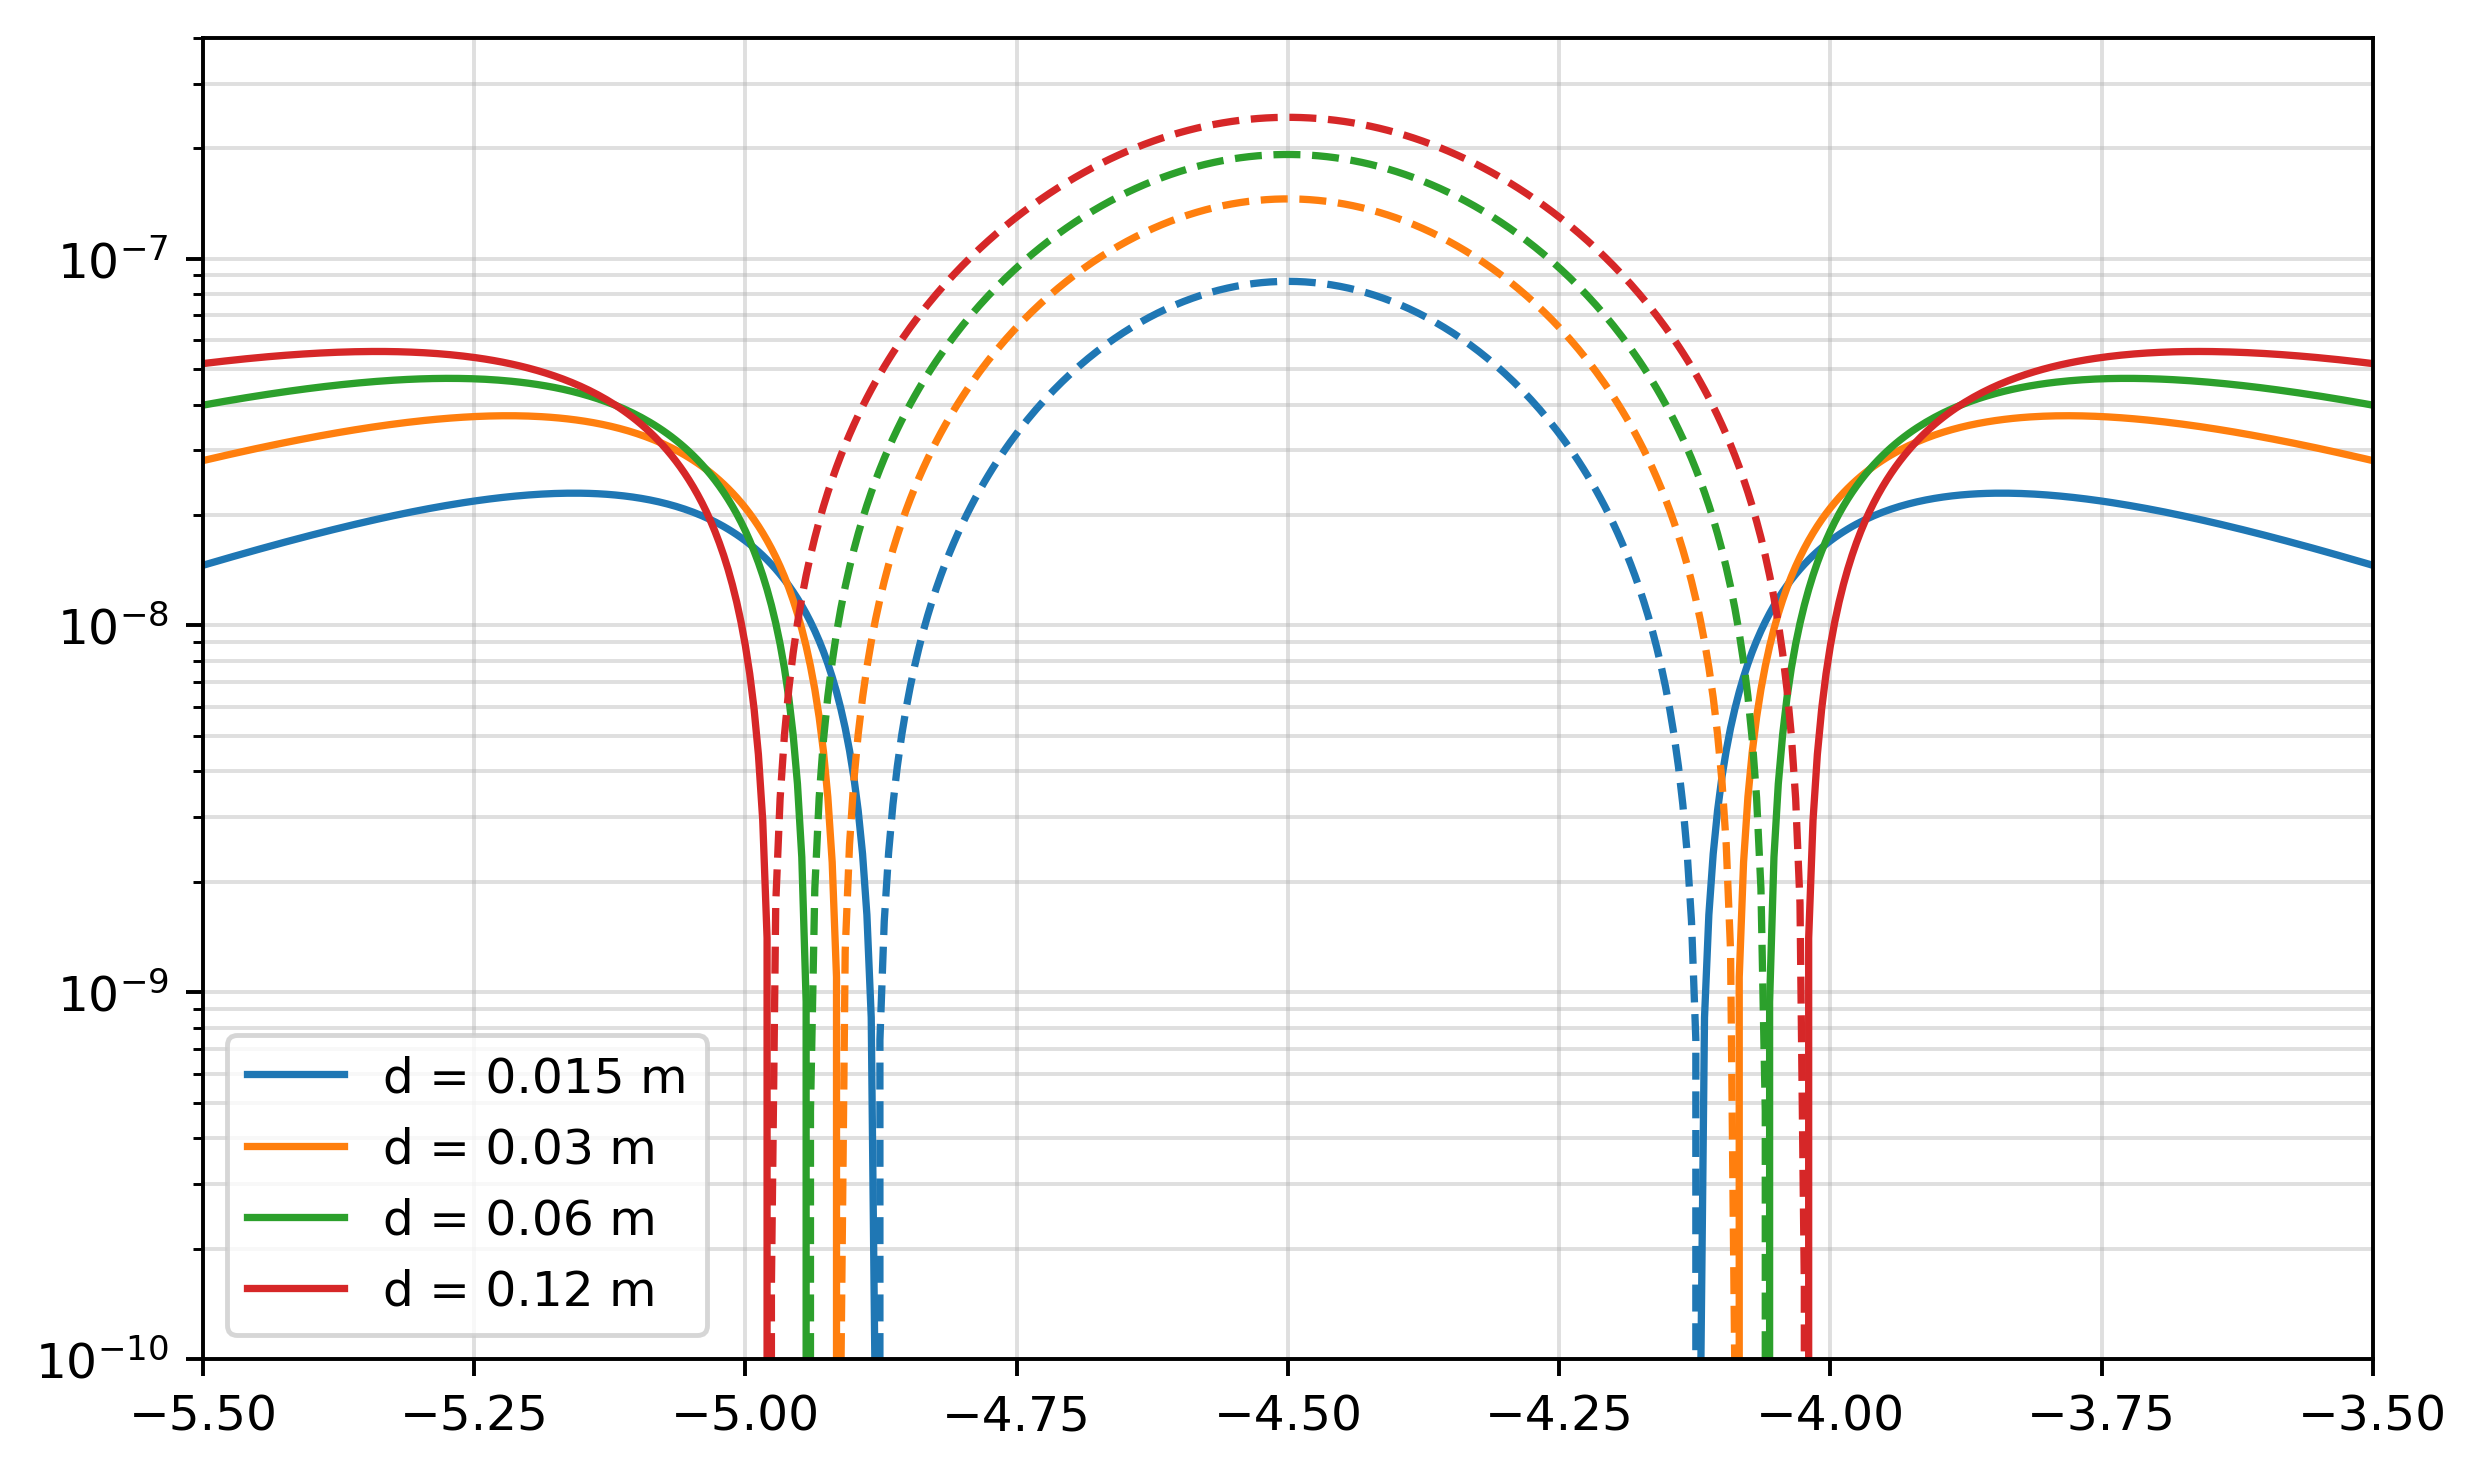

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8, 5), dpi = 350)

for i, key in enumerate(model_names[1:]):
    dat = data_dict[key]
    label = "d = " + key.split('_')[-1] + " m"
    ax.semilogy(z, dat, label=label, color="C{}".format(i))
    ax.semilogy(z, -dat, '--', color="C{}".format(i))

ax.grid(which='both', alpha=0.4)
ax.legend(loc='lower left')
ax.set_ylim([1e-10, 4e-7])
ax.set_xlim([-5.5, -3.5])